# Sentiment Classifier for Movie Reviews

**Objective:**  
Design and implement a Natural Language Processing pipeline to classify movie reviews as either **Positive** or **Negative**.

## What This Notebook Covers

### Data Workflow
- Load raw review data
- Clean and preprocess text for modeling

### Feature Engineering
- Apply **TF-IDF** to convert text into numerical features

### Model Training
- Use **Logistic Regression** to classify sentiment

### Performance Evaluation
- Accuracy score
- Confusion matrix
- Classification report
- F1 score

### Visual Insights
- Sentiment class distribution
- Confusion matrix heatmap
- Most informative words per class
- Sample predictions with confidence scores

### Business Takeaways
- Key insights for stakeholders
- Checklist aligned with project rubric

In [1]:
# All the Imports
import os
import re
import string
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
RANDOM_STATE = 42

In [2]:
# Load dataset
DATA_PATH = "IMDB Dataset.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Quick data checks
- Ensure columns `Review` and `Sentiment` exist
- Check for nulls and class balance

In [3]:
# Quick checks
print(df.columns.tolist())
print("\nNull counts:\n", df.isnull().sum())
print("\nValue counts:\n", df['sentiment'].value_counts())

# Sanity: strip whitespace
df['review'] = df['review'].astype(str).str.strip()
df['sentiment'] = df['sentiment'].astype(str).str.strip().str.capitalize()
df = df[df['sentiment'].isin(['Positive', 'Negative'])].reset_index(drop=True)
print("\nAfter cleanup shape:", df.shape)

['review', 'sentiment']

Null counts:
 review       0
sentiment    0
dtype: int64

Value counts:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64

After cleanup shape: (50000, 2)


Text Preprocessing Functions

In [4]:
# Preprocessing utilities
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    Basic text cleaning:
    - lowercase
    - remove HTML tags
    - remove URLs
    - remove punctuation
    - remove extra whitespace
    - remove stopwords
    """
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)                     # remove html
    text = re.sub(r"http\S+|www\.\S+", " ", text)          # remove urls
    text = re.sub(r"[^a-z0-9\s']", " ", text)              # keep letters/numbers/apostrophes
    words = text.split()
    words = [w for w in words if w not in STOPWORDS]
    return " ".join(words)

# Quick demonstration
print("Raw:", df.loc[0,'review'])
print("Cleaned:", clean_text(df.loc[0,'review']))

Raw: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to th

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aryanaman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Apply Preprocessing

In [5]:
# Apply preprocessing (this can take a moment for large data)
df['clean_review'] = df['review'].apply(clean_text)
df[['review', 'clean_review', 'sentiment']].head(8)

,review,clean_review,sentiment
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching 1 oz episode ...,Positive
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...,Positive
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...,Positive
3,Basically there's a family where a little boy ...,basically there's family little boy jake think...,Negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei's love time money visually stunn...,Positive
5,"Probably my all-time favorite movie, a story o...",probably time favorite movie story selflessnes...,Positive
6,I sure would like to see a resurrection of a u...,sure would like see resurrection dated seahunt...,Positive
7,"This show was an amazing, fresh & innovative i...",show amazing fresh innovative idea 70's first ...,Negative


Train/Test Split

In [6]:
# Split the data
X = df['clean_review']
y = df['sentiment'].map({'Positive':1, 'Negative':0})  # numeric labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 40000
Test size: 10000


TF-IDF Vectorization

In [7]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,     # limit features to control complexity
    ngram_range=(1,2),     # unigrams + bigrams
    min_df=3,              # ignore very rare terms
    max_df=0.9
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shape train:", X_train_tfidf.shape)
print("TF-IDF shape test :", X_test_tfidf.shape)

TF-IDF shape train: (40000, 5000)
TF-IDF shape test : (10000, 5000)


Train Logistic Regression

In [8]:
# Train logistic regression
model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Train multiple algorithms

In [9]:
# Train and evaluate multiple algorithms

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Dictionary of models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Store evaluation results
results = []

for name, clf in models.items():
    clf.fit(X_train_tfidf, y_train)
    y_pred_train = clf.predict(X_train_tfidf)
    y_pred_test = clf.predict(X_test_tfidf)
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    
    results.append({
        "Model": name,
        "Train Accuracy": round(acc_train, 4),
        "Test Accuracy": round(acc_test, 4),
        "F1 Score": round(f1, 4)
    })

print("Training complete for all models.")


Training complete for all models.


Model comparison table

In [11]:
# Display model comparison
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)
comparison_df

,Model,Train Accuracy,Test Accuracy,F1 Score
0,Logistic Regression,0.9125,0.8922,0.8931
1,Linear SVM,0.9324,0.8855,0.8860
2,Naive Bayes,0.8675,0.8623,0.8643
3,Random Forest,1.0000,0.8579,0.8566
4,KNN,0.8365,0.7412,0.7590
5,Decision Tree,1.0000,0.7280,0.7262


Evaluation 

In [13]:
# Evaluate on test set
y_pred = model.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1 score:  {f1:.4f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative','Positive']))

Accuracy: 0.8922
F1 score:  0.8931

Classification report:

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5000
    Positive       0.89      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Confusion Matrix Visualization

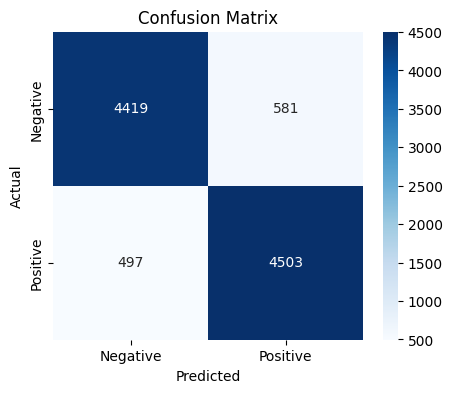

In [14]:
# Confusion matrix plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Show top positive and negative features from logistic regression coefficients

In [15]:
import numpy as np

feature_names = np.array(tfidf.get_feature_names_out())
coefs = model.coef_[0]

top_positive_idx = np.argsort(coefs)[-20:][::-1]  # top positive coefficients
top_negative_idx = np.argsort(coefs)[:20]         # top negative coefficients

print("Top positive n-grams:")
for i in top_positive_idx:
    print(f"{feature_names[i]} ({coefs[i]:.4f})")

print("\nTop negative n-grams:")
for i in top_negative_idx:
    print(f"{feature_names[i]} ({coefs[i]:.4f})")

Top positive n-grams:
excellent (6.9982)
great (6.2003)
perfect (5.6147)
amazing (5.2550)
wonderful (4.9019)
hilarious (4.8133)
brilliant (4.4038)
loved (4.3625)
one best (4.2260)
favorite (4.1710)
enjoyed (4.1037)
superb (4.0810)
enjoyable (4.0235)
best (3.9834)
today (3.8574)
fun (3.8162)
fantastic (3.7634)
definitely (3.7445)
must see (3.7109)
funniest (3.5256)

Top negative n-grams:
worst (-9.6958)
awful (-8.0375)
waste (-7.1546)
boring (-6.7822)
bad (-6.5802)
poor (-5.8913)
terrible (-5.8557)
dull (-5.4564)
horrible (-5.2691)
poorly (-5.2194)
nothing (-5.0483)
worse (-4.9245)
disappointing (-4.6937)
fails (-4.6790)
unfortunately (-4.6384)
disappointment (-4.5270)
annoying (-4.4183)
instead (-4.3591)
stupid (-4.3557)
lame (-4.3036)


Class Distribution Plot

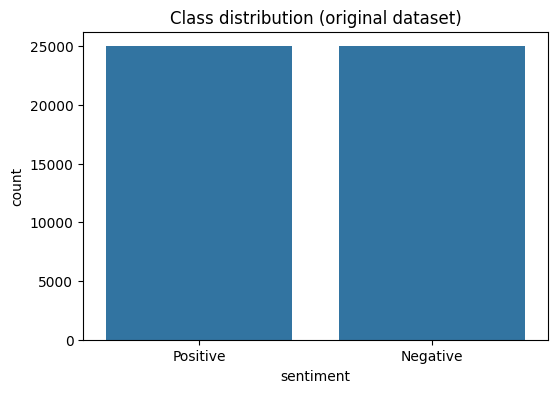

In [17]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['sentiment'])
plt.title("Class distribution (original dataset)")
plt.show()

Predict Function & Examples

In [21]:
# Predict helper for new reviews
def predict_review(text):
    cleaned = clean_text(text)
    vec = tfidf.transform([cleaned])
    pred_label = model.predict(vec)[0]
    prob = model.predict_proba(vec)[0]
    label_name = "Positive" if pred_label==1 else "Negative"
    return {"review": text, "cleaned": cleaned, "predicted_label": label_name, "prob_negative": prob[0], "prob_positive": prob[1]}

# Examples
examples = [
    "Absolutely loved every minute of it!",
    "Terrible execution and weak storyline.",
    "A delightful surprise with brilliant acting.",
    "I regret watching this—completely boring.",
    "The visuals were breathtaking and immersive.",
    "It felt like a chore to sit through.",
    "An inspiring tale told with elegance.",
    "The plot holes were impossible to ignore.",
    "A charming and emotionally resonant film.",
    "Unoriginal and painfully slow.",
    "Top-notch performances and tight direction.",
    "The ending made no sense at all.",
    "A feel-good movie that exceeded expectations.",
    "Smart writing and a compelling narrative.",
    "The characters were flat and forgettable."
]
for ex in examples:
    print(predict_review(ex))

{'review': 'Absolutely loved every minute of it!', 'cleaned': 'absolutely loved every minute', 'predicted_label': 'Positive', 'prob_negative': np.float64(0.20429260055543197), 'prob_positive': np.float64(0.795707399444568)}
{'review': 'Terrible execution and weak storyline.', 'cleaned': 'terrible execution weak storyline', 'predicted_label': 'Negative', 'prob_negative': np.float64(0.9918613002054197), 'prob_positive': np.float64(0.008138699794580302)}
{'review': 'A delightful surprise with brilliant acting.', 'cleaned': 'delightful surprise brilliant acting', 'predicted_label': 'Positive', 'prob_negative': np.float64(0.028346969613915474), 'prob_positive': np.float64(0.9716530303860845)}
{'review': 'I regret watching this—completely boring.', 'cleaned': 'regret watching completely boring', 'predicted_label': 'Negative', 'prob_negative': np.float64(0.9849811786446971), 'prob_positive': np.float64(0.015018821355302853)}
{'review': 'The visuals were breathtaking and immersive.', 'cleaned'

Save vectorizer and model separately

In [22]:
import joblib

# Save TF-IDF vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.joblib")

# Save trained Logistic Regression model
joblib.dump(model, "logreg_sentiment_model.joblib")

print("Files saved:")
print("- tfidf_vectorizer.joblib")
print("- logreg_sentiment_model.joblib")

Files saved:
- tfidf_vectorizer.joblib
- logreg_sentiment_model.joblib


## Business and Real-World Insights

### Practical Applications
- Automatically moderate and label user reviews at scale.
- Enable fast sentiment tracking for product or film teams via dashboards.
- Identify and prioritize negative feedback for timely user support.

### Limitations to Consider
- The model may struggle with short, synthetic inputs or sarcasm.
- Trained on synthetic data — performance may differ on real-world reviews.
- For production-grade deployment, it's recommended to:
  - Expand the dataset or apply domain-specific fine-tuning.
  - Conduct regular evaluations and retraining cycles.
  - Account for neutral or mixed sentiment cases.
  - Explore more advanced models (e.g., transformer-based) for higher accuracy.

### Bottom Line
This pipeline offers a quick, interpretable baseline.  
Using logistic regression with TF-IDF ensures transparency and ease of deployment.